In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

In [2]:
data_dv = pd.read_csv('../data-generator/newest-data-base/full-dv-data.csv')

In [3]:
data_dv.columns

Index(['Campus', 'Sede', 'Nível de ensino', 'Grau', 'Periodicidade',
       'Funcionamento', 'Turno', 'Curso', 'Gênero', 'Ano', 'Semestre', 'Nome',
       'Código', 'Situação', 'Ano de ingresso', 'Calouro',
       'Categoria stricto sensu', 'Coeficiente de rendimento', 'Cor ou raça',
       'Código do curso', 'Código INEP do curso', 'Data de colação de grau',
       'Data de ingresso', 'Data de nascimento', 'Disciplinas aprovadas',
       'Disciplinas consignadas', 'Disciplinas matriculadas',
       'Disciplinas reprovadas por frequência',
       'Disciplinas reprovadas por nota', 'E-mail', 'Forma de ingresso',
       'Idade', 'Matriz curricular', 'Mudou de curso - mesmo campus',
       'Mudou de curso - outro campus', 'Município', 'Município SiSU',
       'Nota ENEM Humanas', 'Nota ENEM Liguagem', 'Nota ENEM Matemática',
       'Nota ENEM Natureza', 'Nota ENEM Redação',
       'Nota final (SiSU/Vestibular)', 'Nota Vestibular Biologia',
       'Nota Vestibular Filosofia e Sociologia', 

In [4]:
data_dv['Nível de ensino'].value_counts()

Nível de ensino
Graduação    44129
Name: count, dtype: int64

In [5]:
data_dv.shape

(44129, 69)

In [6]:
data_dv['Curso'].value_counts()

Curso
Bacharelado Em Zootecnia                        10013
Bacharelado Em Agronomia                         9526
Engenharia Florestal                             7974
Bacharelado Em Engenharia De Software            6270
Licenciatura Em Ciências Biológicas              5727
Engenharia De Bioprocessos E Biotecnologia       3415
Licenciatura Em Educação No Campo                 958
Curso Superior De Tecnologia Em Horticultura      246
Name: count, dtype: int64

In [7]:
data_dv = data_dv[(data_dv['Nível de ensino'] == "Graduação") & 
        (data_dv['Curso'] != 'Curso Superior De Tecnologia Em Horticultura')]

In [8]:
data_dv.shape

(43883, 69)

In [9]:
data_dv['Curso'].value_counts()

Curso
Bacharelado Em Zootecnia                      10013
Bacharelado Em Agronomia                       9526
Engenharia Florestal                           7974
Bacharelado Em Engenharia De Software          6270
Licenciatura Em Ciências Biológicas            5727
Engenharia De Bioprocessos E Biotecnologia     3415
Licenciatura Em Educação No Campo               958
Name: count, dtype: int64

In [10]:
data_dv_sorted = data_dv.sort_values(by=['Nome', 'Ano', 'Semestre', 'Período'], ascending=[True, True, True, True])
data_dv_last_occurence = data_dv_sorted.drop_duplicates(subset='Nome', keep='last')
data_dv_last_occurence.reset_index(drop=True, inplace=True)

In [11]:
data_dv_last_occurence.shape

(5656, 69)

In [12]:
data_dv_last_occurence['Curso'].value_counts()

Curso
Bacharelado Em Zootecnia                      1224
Bacharelado Em Agronomia                      1156
Engenharia Florestal                           907
Licenciatura Em Ciências Biológicas            902
Bacharelado Em Engenharia De Software          885
Engenharia De Bioprocessos E Biotecnologia     432
Licenciatura Em Educação No Campo              150
Name: count, dtype: int64

In [13]:
data_dv = data_dv.rename(columns={'Situação atual': 'Situação'})
data_dv_last_occurence = data_dv_last_occurence.rename(columns={'Situação atual': 'Situação'})

In [14]:
data_dv['Situação'].value_counts()

Situação
Regular                 35413
Trancado                 3583
Desistente               2770
Formado                  1660
Afastado                  233
Transferido               119
Mudou de Curso             51
Enade pendente             39
Matrícula sub judice        6
Falecido                    5
Expulso                     2
Jubilado                    2
Name: count, dtype: int64

In [15]:
data_dv_last_occurence['Situação'].value_counts()

Situação
Desistente        2376
Formado           1638
Regular           1337
Trancado           157
Transferido        118
Afastado            12
Enade pendente      10
Falecido             5
Jubilado             2
Expulso              1
Name: count, dtype: int64

In [16]:
data_dv_last_occurence['Situação'].value_counts()

Situação
Desistente        2376
Formado           1638
Regular           1337
Trancado           157
Transferido        118
Afastado            12
Enade pendente      10
Falecido             5
Jubilado             2
Expulso              1
Name: count, dtype: int64

In [17]:
data_dv["Nome"].nunique()

5656

In [18]:
def remove_columns(df):
    columns_to_remove = ['Campus', 'Sede', 'Nome', 'Código', 'Data de ingresso', 'Data de nascimento', 'Matriz curricular', 
                         'Município', 'Município SiSU', 'Município (SISU)', 'UF SISU', 'UF (SISU)', 'E-mail', 'Funcionamento', 'Sede']
    return df.drop(columns=[col for col in columns_to_remove if col in df.columns])

data_dv = remove_columns(data_dv)
data_dv_last_occurence = remove_columns(data_dv_last_occurence)

In [19]:
# Função de pré-processamento
def pre_process(data, dataset_name="Dataset"):
    print(f"==> Pré-processando o {dataset_name}...")
    
    # Remover colunas com nome "Unnamed"
    unnamed_columns = data.columns[data.columns.str.contains('^Unnamed')].tolist()
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    print("Colunas removidas com 'Unnamed':", unnamed_columns)
    
    # Remover colunas com mais de 50% de valores ausentes
    threshold_na = len(data) * 0.5
    na_columns = data.columns[data.isna().mean() > 0.5].tolist()
    data = data.dropna(axis=1, thresh=threshold_na)
    print(f"Colunas removidas por mais de 50% de valores ausentes:", na_columns)
    
    # Transformar variáveis categóricas em numéricas
    columns = data.columns.tolist()
    for column in columns:
        if data[column].dtype == 'object':
            data.loc[:, column] = pd.Categorical(data[column])
            data.loc[:, column] = LabelEncoder().fit_transform(data[column])
        
        # Trocar vírgula por ponto para conversão em numérico
        data.loc[:, column] = data[column].astype(str).str.replace(',', '.')
        data.loc[:, column] = pd.to_numeric(data[column], errors='coerce')
    
    print("Pré-processamento finalizado.")
    return data

data = pre_process(data_dv)


==> Pré-processando o Dataset...
Colunas removidas com 'Unnamed': []
Colunas removidas por mais de 50% de valores ausentes: ['Categoria stricto sensu', 'Data de colação de grau', 'Nota Vestibular Biologia', 'Nota Vestibular Filosofia e Sociologia', 'Nota Vestibular Física', 'Nota Vestibular Geografia', 'Nota Vestibular História', 'Nota Vestibular Literatura Brasileira', 'Nota Vestibular Língua Estrangeira Moderna (Espanhol ou Inglês)', 'Nota Vestibular Língua Portuguesa', 'Nota Vestibular Matemática', 'Nota Vestibular Química']
Pré-processamento finalizado.


In [20]:
def const_remove_analysis(data, thresholds=[0.05, 0.1, 0.15, 0.2]):
    results = {}
    for threshold in thresholds:
        print(f"\n==> Analisando com threshold de variância = {threshold}...")
        
        # Aplicando filtro de variância
        constant_filter = VarianceThreshold(threshold)
        constant_filter.fit(data)
        columns_to_keep = data.columns[constant_filter.get_support()].tolist()
        columns_to_drop = [col for col in data.columns if col not in columns_to_keep]
        
        # Exibir o resultado para o threshold atual
        print(f"Colunas removidas ({len(columns_to_drop)}) para threshold = {threshold}:")
        print(columns_to_drop)
        
        # Armazenar o resultado para análise posterior
        results[threshold] = {
            "columns_removed": columns_to_drop,
            "num_removed": len(columns_to_drop),
            "num_remaining": len(columns_to_keep)
        }
    
    return results

# Executar a função de análise de variância no dataset
analysis_results = const_remove_analysis(data)


==> Analisando com threshold de variância = 0.05...
Colunas removidas (11) para threshold = 0.05:
['Nível de ensino', 'Periodicidade', 'Calouro', 'Coeficiente de rendimento', 'Mudou de curso - mesmo campus', 'Mudou de curso - outro campus', 'Número de entradas no curso', 'Ordem de ingresso no curso', 'Provável jubilamento', 'Regime de ensino', 'Sede.1']

==> Analisando com threshold de variância = 0.1...
Colunas removidas (12) para threshold = 0.1:
['Nível de ensino', 'Periodicidade', 'Calouro', 'Coeficiente de rendimento', 'Mudou de curso - mesmo campus', 'Mudou de curso - outro campus', 'Número de entradas em outros cursos', 'Número de entradas no curso', 'Ordem de ingresso no curso', 'Provável jubilamento', 'Regime de ensino', 'Sede.1']

==> Analisando com threshold de variância = 0.15...
Colunas removidas (13) para threshold = 0.15:
['Nível de ensino', 'Periodicidade', 'Calouro', 'Coeficiente de rendimento', 'Mudou de curso - mesmo campus', 'Mudou de curso - outro campus', 'Número

In [21]:
def const_remove_analysis(data, columns_imputed, thresholds=[0.05, 0.1, 0.15, 0.2]):
    results = {}
    for threshold in thresholds:
        print(f"\n==> Analisando com threshold de variância = {threshold}...")
        
        # Aplicando filtro de variância
        constant_filter = VarianceThreshold(threshold)
        constant_filter.fit(data)
        columns_to_keep = data.columns[constant_filter.get_support()].tolist()
        columns_to_drop = [col for col in data.columns if col not in columns_to_keep]
        
        # Verificar se colunas imputadas são removidas
        imputed_columns_dropped = [col for col in columns_imputed if col in columns_to_drop]
        
        # Exibir o resultado para o threshold atual
        print(f"Colunas removidas ({len(columns_to_drop)}) para threshold = {threshold}:")
        print(columns_to_drop)
        print(f"Colunas imputadas removidas para threshold = {threshold}:")
        print(imputed_columns_dropped)
        
        # Armazenar o resultado para análise posterior
        results[threshold] = {
            "columns_removed": columns_to_drop,
            "imputed_columns_removed": imputed_columns_dropped,
            "num_removed": len(columns_to_drop),
            "num_remaining": len(columns_to_keep)
        }
    
    return results

# Obtenha a lista de colunas imputadas (que tinham valores ausentes)
columns_with_na = data.columns[data.isna().any()].tolist()

# Executar a função de análise de variância no dataset
analysis_results = const_remove_analysis(data, columns_with_na)



==> Analisando com threshold de variância = 0.05...
Colunas removidas (11) para threshold = 0.05:
['Nível de ensino', 'Periodicidade', 'Calouro', 'Coeficiente de rendimento', 'Mudou de curso - mesmo campus', 'Mudou de curso - outro campus', 'Número de entradas no curso', 'Ordem de ingresso no curso', 'Provável jubilamento', 'Regime de ensino', 'Sede.1']
Colunas imputadas removidas para threshold = 0.05:
['Coeficiente de rendimento']

==> Analisando com threshold de variância = 0.1...
Colunas removidas (12) para threshold = 0.1:
['Nível de ensino', 'Periodicidade', 'Calouro', 'Coeficiente de rendimento', 'Mudou de curso - mesmo campus', 'Mudou de curso - outro campus', 'Número de entradas em outros cursos', 'Número de entradas no curso', 'Ordem de ingresso no curso', 'Provável jubilamento', 'Regime de ensino', 'Sede.1']
Colunas imputadas removidas para threshold = 0.1:
['Coeficiente de rendimento']

==> Analisando com threshold de variância = 0.15...
Colunas removidas (13) para thresho

In [22]:
def imputation(data):
    print("==> Imputando valores ausentes com a média das colunas...")
    
    # Calcular e exibir a porcentagem de valores ausentes por coluna
    missing_percentage = data.isna().mean() * 100
    missing_data = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
    
    print("Percentual de valores ausentes em cada coluna (antes da imputação):")
    print(missing_data)
    
    # Exibir apenas as colunas com valores ausentes
    columns_with_na = data.columns[data.isna().any()].tolist()
    print("\nColunas com valores ausentes antes da imputação:", columns_with_na)
    
    # Realizar a imputação com a média
    imputer = SimpleImputer(strategy='mean')
    df_imputed = imputer.fit_transform(data)
    data = pd.DataFrame(data=df_imputed, columns=data.columns)
    
    print("Imputação finalizada.")
    return data

# Executar a função de imputação no dataset
data = imputation(data)

==> Imputando valores ausentes com a média das colunas...
Percentual de valores ausentes em cada coluna (antes da imputação):
Nota ENEM Humanas               13.839072
Nota ENEM Natureza              13.839072
Nota ENEM Redação               13.839072
Nota ENEM Liguagem              13.485860
Nota ENEM Matemática            13.485860
Nota final (SiSU/Vestibular)    13.016430
Coeficiente de rendimento        0.278012
dtype: float64

Colunas com valores ausentes antes da imputação: ['Coeficiente de rendimento', 'Nota ENEM Humanas', 'Nota ENEM Liguagem', 'Nota ENEM Matemática', 'Nota ENEM Natureza', 'Nota ENEM Redação', 'Nota final (SiSU/Vestibular)']
Imputação finalizada.


In [23]:
def const_remove(data, threshold=0.01):
    print("==> Removendo colunas com variância baixa...")
    
    # Aplicando filtro de variância
    constant_filter = VarianceThreshold(threshold)
    constant_filter.fit(data)
    columns_to_keep = data.columns[constant_filter.get_support()].tolist()
    columns_to_drop = [col for col in data.columns if col not in columns_to_keep]
    
    print("Colunas removidas por baixa variância:", columns_to_drop)
    data = data[columns_to_keep]
    
    return data

data = const_remove(data)


==> Removendo colunas com variância baixa...
Colunas removidas por baixa variância: ['Nível de ensino', 'Periodicidade', 'Calouro', 'Mudou de curso - outro campus', 'Número de entradas no curso', 'Ordem de ingresso no curso', 'Regime de ensino', 'Sede.1']


In [27]:
def correlation(data, thresholds=[0.8, 0.85, 0.9, 0.95]):
    print("==> Analisando colunas com alta correlação para diferentes thresholds...")
    
    # Calculando a correlação
    corr = data.corr()
    
    for threshold in thresholds:
        print(f"\nThreshold: {threshold}")
        
        # Identificar colunas para remoção com base no threshold de correlação
        mask = (corr > threshold) | (corr < -threshold)
        columns_to_drop = []
        
        for col in mask.columns:
            correlated_cols = mask.index[mask[col]].tolist()
            if len(correlated_cols) > 1:
                columns_to_drop.extend(correlated_cols[1:])  # Manter a primeira coluna, remover as subsequentes
        
        columns_to_drop = list(set(columns_to_drop))  # Remover duplicatas
        print(f"Colunas removidas por alta correlação (threshold {threshold}): {columns_to_drop}")
    
    return data

result = correlation(data)


==> Analisando colunas com alta correlação para diferentes thresholds...

Threshold: 0.8
Colunas removidas por alta correlação (threshold 0.8): ['Código INEP do curso', 'Disciplinas matriculadas', 'Total de períodos do curso', 'Total de semestres cursados', 'Ano de ingresso']

Threshold: 0.85
Colunas removidas por alta correlação (threshold 0.85): ['Código INEP do curso', 'Ano de ingresso']

Threshold: 0.9
Colunas removidas por alta correlação (threshold 0.9): []

Threshold: 0.95
Colunas removidas por alta correlação (threshold 0.95): []


==> Removendo colunas com alta correlação...


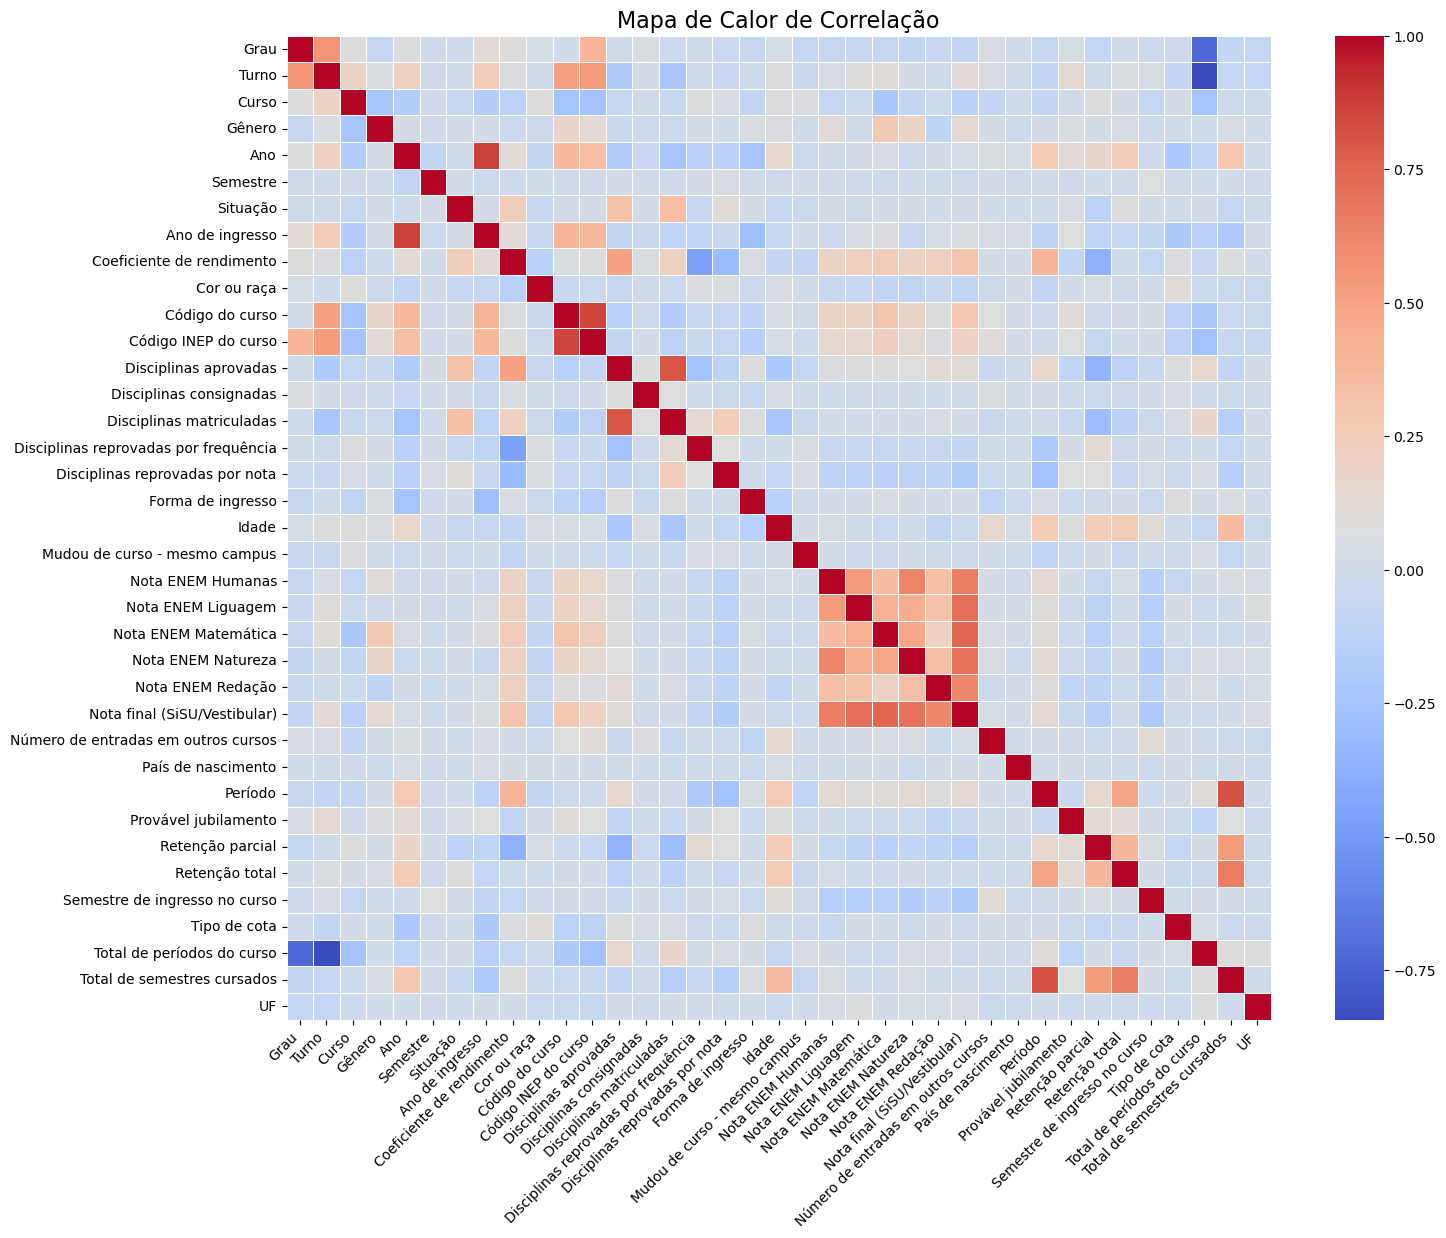

Colunas removidas por alta correlação: []


In [25]:
def correlation(data, threshold=0.9):
    print("==> Removendo colunas com alta correlação...")
    
    # Calculando a correlação
    corr = data.corr()
    
    # Plotar o mapa de calor da correlação
    plt.figure(figsize=(16, 12))  # Aumentar o tamanho da figura
    sns.heatmap(corr, cmap="coolwarm", annot=False, cbar=True, 
                square=True, fmt=".2f", linewidths=0.5)
    plt.xticks(rotation=45, ha='right')  # Rotacionar rótulos do eixo x
    plt.yticks(rotation=0)  # Manter rótulos do eixo y sem rotação
    plt.title("Mapa de Calor de Correlação", fontsize=16)
    
    # Ajustar o espaçamento do gráfico
    plt.subplots_adjust(top=0.92, bottom=0.1, left=0.1, right=0.9)
    
    # Salvar o gráfico como PDF, ajustando o layout para remover espaços em branco
    plt.savefig("correlation_heatmap.pdf", format="pdf", bbox_inches='tight')
    plt.show()
    
    # Identificar colunas para remoção com base no threshold de correlação
    mask = (corr > threshold) | (corr < -threshold)
    columns_to_drop = []
    for col in mask.columns:
        correlated_cols = mask.index[mask[col]].tolist()
        if len(correlated_cols) > 1:
            columns_to_drop.extend(correlated_cols[1:])  # Manter a primeira coluna, remover as subsequentes
    
    columns_to_drop = list(set(columns_to_drop))  # Remover duplicatas
    print("Colunas removidas por alta correlação:", columns_to_drop)
    
    data = data.drop(columns=columns_to_drop)
    return data

# Executar a função de correlação no dataset
data = correlation(data)


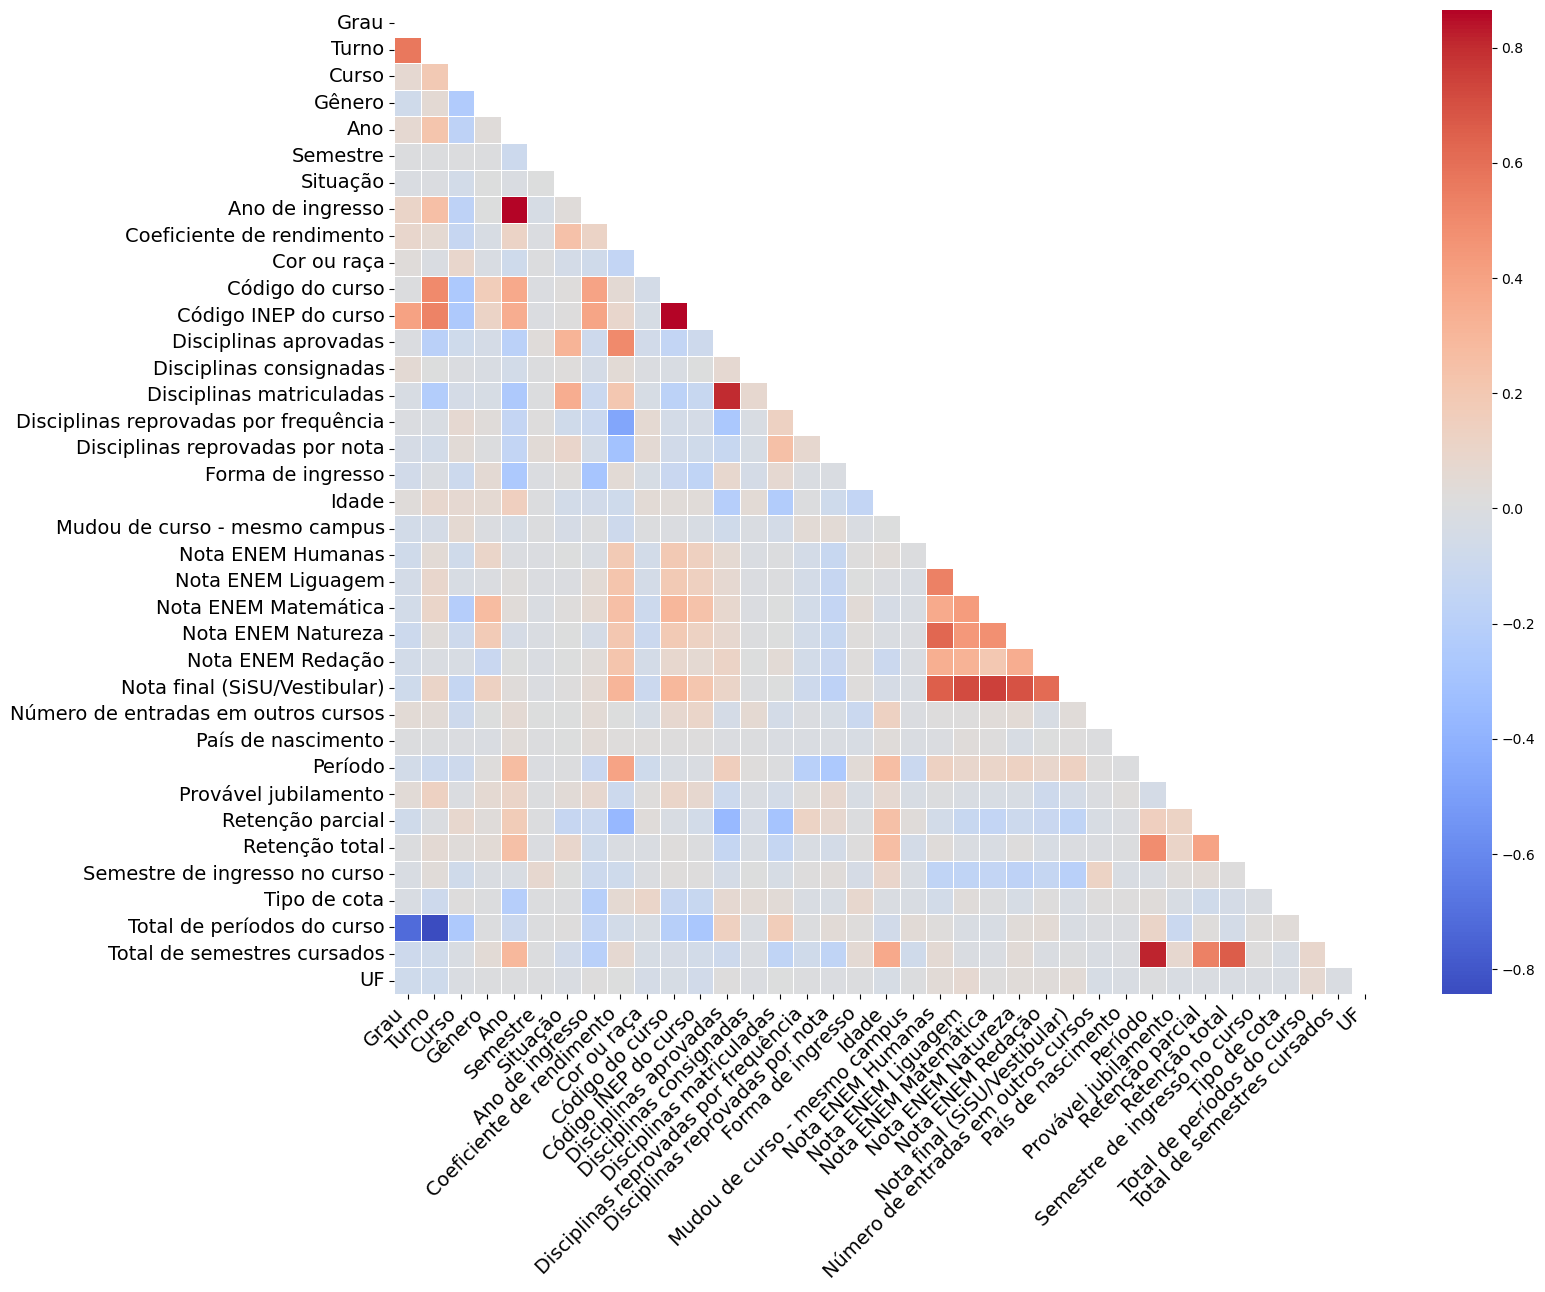

Colunas removidas por alta correlação: []


In [64]:
def correlation(data, threshold=0.9):
    corr = data.corr()
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    plt.figure(figsize=(16, 12))  
    sns.heatmap(
        corr, mask=mask, cmap="coolwarm", annot=False, cbar=True, 
        square=True, fmt=".2f", linewidths=0.5
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=14) 
    plt.yticks(rotation=0, fontsize=14)  
    
    plt.subplots_adjust(top=0.92, bottom=0.1, left=0.1, right=0.9)
    
    plt.savefig("correlation_heatmap.pdf", format="pdf", bbox_inches='tight')
    plt.show()
    
    mask_corr = (corr > threshold) | (corr < -threshold)
    columns_to_drop = []
    for col in mask_corr.columns:
        correlated_cols = mask_corr.index[mask_corr[col]].tolist()
        if len(correlated_cols) > 1:
            columns_to_drop.extend(correlated_cols[1:])
    
    columns_to_drop = list(set(columns_to_drop))  
    print("Colunas removidas por alta correlação:", columns_to_drop)
    
    data = data.drop(columns=columns_to_drop)
    return data

data = correlation(data)
